# TalkingData AdTracking 
This dataset is huge , one of the biggest i have ever seen.

For this dataset, the objective is to predict whether a user will download an app after clicking a mobile app advertisement. Since, they have given a small training sample, we will first explore the dataset using this sample training set.

First let us import the necessary libraries and have a look at the data



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os 


train=pd.read_csv('data/mnt_sample/ssd/kaggle-talkingdata2/competition_files/train_sample.csv')
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [2]:
train.shape

(100000, 8)

## Data fields

Each row of the training data contains a click record, with the following features.

- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded
Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

- click_id: reference for making predictions
- is_attributed: not included


The evaluation metric used is ROC curve, the AUC of the ROC graph. Let us have a look at the actual train and test set below 

In [3]:
#let us have a look at the file sizes and the no of data points in them
for f in os.listdir('data/'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('data/' + f) / 1000000, 2)) + 'MB')


mnt_sample                    0.0MB
mnt                           0.0MB
sample_submission.csv         195.58MB
test.csv                      863.27MB
train.csv                     7537.65MB


In [4]:
train_df = pd.read_csv('data/train.csv',nrows=40000000)

In [5]:
train_df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [6]:
test_df=pd.read_csv('data/test.csv')

In [8]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


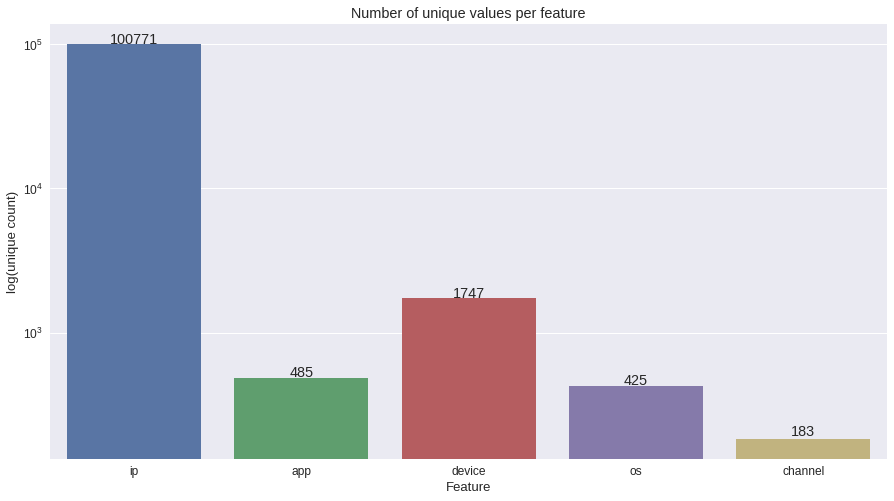

In [19]:
#plotting unique features
plt.figure(figsize=(15,8))
cols=['ip','app','device','os','channel']
unique_list=[len(train_df[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, unique_list, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, unique_list):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

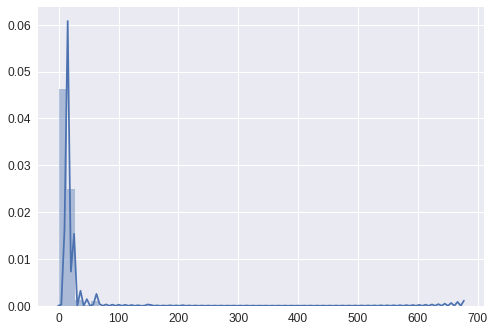

In [32]:
sns.distplot(train_df['app'])

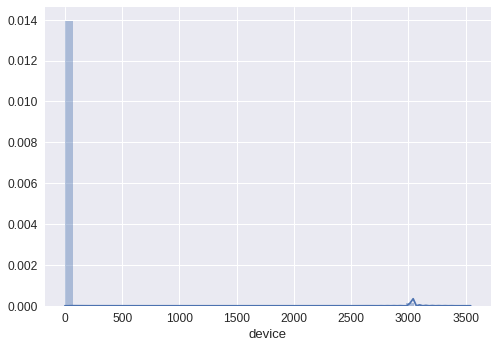

In [33]:
sns.distplot(train_df['device'])

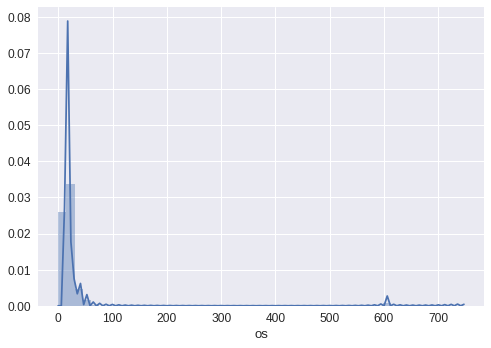

In [34]:
sns.distplot(train_df['os'])